In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

In [134]:

# Load mimic-iv-3.1 data (adjust paths as needed)
admissions = pd.read_csv('mimic-iv-3.1/hosp/admissions.csv')
patients = pd.read_csv('mimic-iv-3.1/hosp/patients.csv')
diagnoses = pd.read_csv('mimic-iv-3.1/hosp/diagnoses_icd.csv')
icustays = pd.read_csv('mimic-iv-3.1/icu/icustays.csv')

# Identify heart failure patients (ICD-10: I50.x)
hf_diagnoses = diagnoses[diagnoses['icd_code'].str.startswith('I50', na=False)]
hf_hadm_ids = hf_diagnoses['hadm_id'].unique()

# Filter admissions to heart failure cohort
df = admissions[admissions['hadm_id'].isin(hf_hadm_ids)].merge(
    patients[['subject_id', 'anchor_age', 'gender']], on='subject_id', how='inner'
).merge(
    icustays[['hadm_id', 'first_careunit']], on='hadm_id', how='left'
).merge(
    diagnoses[['hadm_id', 'icd_code']], on='hadm_id', how='left'
)

# Define target variable: in-hospital mortality
df['mortality'] = df['deathtime'].notnull().astype(int)

# Calculate age at admission
df['age'] = df['anchor_age']  # mimic-iv-3.1 uses anchor_age
df.loc[df['age'] > 90, 'age'] = 90  # Cap age as per MIMIC convention

# Feature engineering
df['gender'] = df['gender'].map({'M': 0, 'F': 1})
df['icu_stay'] = df['first_careunit'].notnull().astype(int)
df['admission_type'] = pd.Categorical(df['admission_type']).codes

# Simplify ICD-10 codes (first 3 characters, exclude I50)
df['icd_code'] = df['icd_code'].fillna('999').str.slice(0, 3)
diag_pivot = pd.get_dummies(df.groupby('hadm_id')['icd_code'].apply(
    lambda x: x[x != 'I50'].value_counts().index[0] if len(x[x != 'I50']) > 0 else '999'
)).reset_index()
df = df.drop_duplicates('hadm_id').merge(diag_pivot, on='hadm_id', how='left')

# Select features and target
features = ['age', 'gender', 'icu_stay', 'admission_type'] + [col for col in df.columns if col.startswith('ICD')]
X = df[features].fillna(0)
y = df['mortality']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Full Training Set Size: {len(X_train)} samples", flush=True)
print(f"Full Test Set Size: {len(X_test)} samples", flush=True)
print(f"Mortality Rate: {y.mean():.2%}", flush=True)

Full Training Set Size: 34392 samples
Full Test Set Size: 8598 samples
Mortality Rate: 5.40%


Training XGBoost on full dataset...
XGBoost Metrics (Full Dataset): {'Accuracy': 0.9456850430332635, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'AUC-ROC': 0.8391732394037799}
XGBoost training and evaluation completed in 0.15 seconds


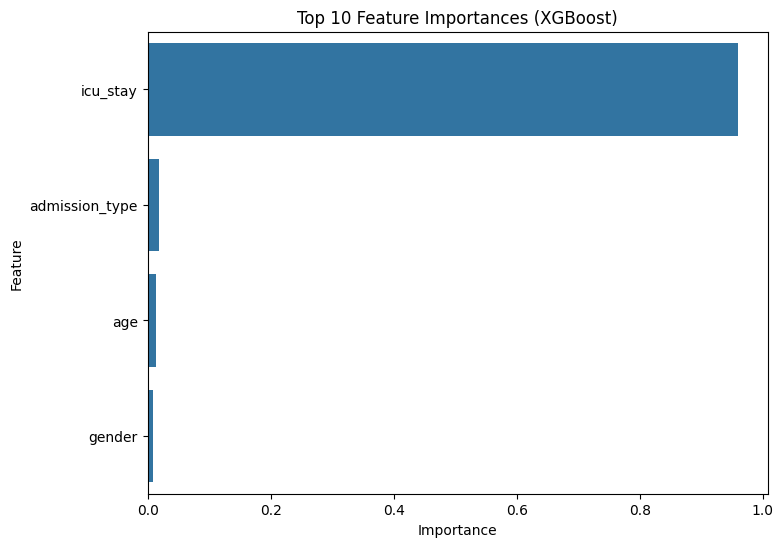

In [135]:
# Use the full dataset (no reduction)
X_train_scaled_full = X_train_scaled  # 34,392 samples
y_train_full = y_train
X_test_scaled_full = X_test_scaled    # 8,598 samples
y_test_full = y_test

# Train XGBoost model on full dataset
start_time = time.time()
print("Training XGBoost on full dataset...", flush=True)
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled_full, y_train_full)

# Predict and evaluate on full test set
y_pred_xgb = xgb_model.predict(X_test_scaled_full)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled_full)[:, 1]

# Metrics
xgb_metrics = {
    'Accuracy': accuracy_score(y_test_full, y_pred_xgb),
    'Precision': precision_score(y_test_full, y_pred_xgb),
    'Recall': recall_score(y_test_full, y_pred_xgb),
    'F1': f1_score(y_test_full, y_pred_xgb),
    'AUC-ROC': roc_auc_score(y_test_full, y_pred_proba_xgb)
}
print("XGBoost Metrics (Full Dataset):", xgb_metrics, flush=True)
print(f"XGBoost training and evaluation completed in {time.time() - start_time:.2f} seconds", flush=True)

# Feature importance
feature_imp = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_model.feature_importances_})
feature_imp = feature_imp.sort_values('Importance', ascending=False).head(10)
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp)
plt.title('Top 10 Feature Importances (XGBoost)')
plt.show()

In [138]:
# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
            nn.Dropout(0.2),  # Reduced dropout
            nn.Linear(out_features, out_features),
            nn.BatchNorm1d(out_features)
        )
        self.shortcut = nn.Sequential()
        if in_features != out_features:
            self.shortcut = nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.BatchNorm1d(out_features)
            )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        identity = self.shortcut(x)
        out = self.block(x)
        out += identity
        out = self.relu(out)
        return out

# Define an improved Feedforward Neural Network with Residual Connections
class AdvancedFNN(nn.Module):
    def __init__(self, input_dim):
        super(AdvancedFNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            ResidualBlock(256, 128),
            nn.Dropout(0.2),
            ResidualBlock(128, 64),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)  # Output logits (no sigmoid)
        )
    
    def forward(self, x):
        return self.network(x)

# Focal Loss implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=3.0):  # Adjusted alpha and gamma
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()

# Start timing
start_time = time.time()

# Use the full dataset
print("Using full dataset for FNN...", flush=True)
print(f"X_train_scaled shape: {X_train_scaled.shape}", flush=True)
print(f"y_train length: {len(y_train)}", flush=True)

# Limit PyTorch threads to avoid contention
torch.set_num_threads(1)

# Split training data into train and validation sets (80/20 split)
X_train_fnn, X_val_fnn, y_train_fnn, y_val_fnn = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Apply synthetic noise to training data for augmentation
X_train_fnn_augmented = X_train_fnn + np.random.normal(0, 0.05, X_train_fnn.shape)  # Increased noise

# Prepare datasets
print("Creating TensorDatasets...", flush=True)
train_dataset = TensorDataset(torch.tensor(X_train_fnn_augmented, dtype=torch.float32),
                              torch.tensor(y_train_fnn.values, dtype=torch.float32).unsqueeze(1))
val_dataset = TensorDataset(torch.tensor(X_val_fnn, dtype=torch.float32),
                            torch.tensor(y_val_fnn.values, dtype=torch.float32).unsqueeze(1))
print(f"Train TensorDataset created with {len(train_dataset)} samples", flush=True)
print(f"Val TensorDataset created with {len(val_dataset)} samples", flush=True)

print("Creating DataLoaders...", flush=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
print(f"Train DataLoader created with {len(train_loader)} batches in {time.time() - start_time:.2f} seconds", flush=True)
print(f"Val DataLoader created with {len(val_loader)} batches", flush=True)

# Initialize model
print("Initializing Advanced FNN model...", flush=True)
input_dim = X_train_scaled.shape[1]
fnn_model = AdvancedFNN(input_dim)

# Use Focal Loss with adjusted parameters
criterion = FocalLoss(alpha=0.5, gamma=3.0)
optimizer = optim.Adam(fnn_model.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training loop with early stopping and gradient clipping
epochs = 50
best_val_loss = float('inf')
patience = 10
early_stop_counter = 0

print("Training Advanced Feedforward Neural Network...", flush=True)
for epoch in range(epochs):
    # Training phase
    fnn_model.train()
    total_train_loss = 0
    num_batches = len(train_loader)
    print(f"Starting Epoch {epoch+1}/{epochs} at {time.time() - start_time:.2f} seconds", flush=True)
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        if batch_idx == 0:
            print(f"First batch processed at {time.time() - start_time:.2f} seconds", flush=True)
        optimizer.zero_grad()
        outputs = fnn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(fnn_model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        total_train_loss += loss.item()
        
        if (batch_idx + 1) % (num_batches // 5) == 0 or (batch_idx + 1) == num_batches:
            progress = (batch_idx + 1) / num_batches * 100
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{num_batches}, "
                  f"Progress: {progress:.1f}%, Batch Loss: {loss.item():.4f}", flush=True)
    
    avg_train_loss = total_train_loss / num_batches
    print(f"Epoch {epoch+1}/{epochs} Training Loss: {avg_train_loss:.4f}", flush=True)

    # Validation phase
    fnn_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = fnn_model(X_val_batch)
            val_loss = criterion(val_outputs, y_val_batch)
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{epochs} Validation Loss: {avg_val_loss:.4f}", flush=True)

    # Learning rate scheduler step
    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(fnn_model.state_dict(), 'best_fnn_model.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss", flush=True)
            break

# Load the best model for evaluation
fnn_model.load_state_dict(torch.load('best_fnn_model.pth'))

# Evaluate on full test set with threshold tuning
fnn_model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_pred_logits_fnn = fnn_model(X_test_tensor).numpy().flatten()
    y_pred_proba_fnn = torch.sigmoid(torch.tensor(y_pred_logits_fnn)).numpy()

# Threshold tuning: Maximize F1-score with minimum recall constraint
thresholds = np.arange(0.1, 0.9, 0.05)  # Finer granularity
best_f1 = 0
best_threshold = 0.5
min_recall = 0.7  # Ensure recall stays above 0.7
for thresh in thresholds:
    y_pred_fnn = (y_pred_proba_fnn > thresh).astype(int)
    recall = recall_score(y_test, y_pred_fnn)
    if recall >= min_recall:
        f1 = f1_score(y_test, y_pred_fnn)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

print(f"Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.4f}", flush=True)

# Final evaluation with best threshold
y_pred_fnn = (y_pred_proba_fnn > best_threshold).astype(int)

# Metrics
fnn_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_fnn),
    'Precision': precision_score(y_test, y_pred_fnn),
    'Recall': recall_score(y_test, y_pred_fnn),
    'F1': f1_score(y_test, y_pred_fnn),
    'AUC-ROC': roc_auc_score(y_test, y_pred_proba_fnn)
}
print("\nAdvanced Feedforward Neural Network Metrics (with Threshold Tuning):", fnn_metrics, flush=True)
print(f"FNN training and evaluation completed in {time.time() - start_time:.2f} seconds", flush=True)

# Ensemble with XGBoost
y_pred_proba_ensemble = 0.5 * y_pred_proba_xgb + 0.5 * y_pred_proba_fnn
y_pred_ensemble = (y_pred_proba_ensemble > 0.5).astype(int)
ensemble_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_ensemble),
    'Precision': precision_score(y_test, y_pred_ensemble),
    'Recall': recall_score(y_test, y_pred_ensemble),
    'F1': f1_score(y_test, y_pred_ensemble),
    'AUC-ROC': roc_auc_score(y_test, y_pred_proba_ensemble)
}
print("Ensemble Metrics:", ensemble_metrics, flush=True)

Using full dataset for FNN...
X_train_scaled shape: (34392, 4)
y_train length: 34392
Creating TensorDatasets...
Train TensorDataset created with 27513 samples
Val TensorDataset created with 6879 samples
Creating DataLoaders...
Train DataLoader created with 215 batches in 0.03 seconds
Val DataLoader created with 54 batches
Initializing Advanced FNN model...
Training Advanced Feedforward Neural Network...
Starting Epoch 1/50 at 0.04 seconds
First batch processed at 0.06 seconds
Epoch 1/50, Batch 43/215, Progress: 20.0%, Batch Loss: 0.0154
Epoch 1/50, Batch 86/215, Progress: 40.0%, Batch Loss: 0.0175
Epoch 1/50, Batch 129/215, Progress: 60.0%, Batch Loss: 0.0169
Epoch 1/50, Batch 172/215, Progress: 80.0%, Batch Loss: 0.0120
Epoch 1/50, Batch 215/215, Progress: 100.0%, Batch Loss: 0.0103
Epoch 1/50 Training Loss: 0.0131
Epoch 1/50 Validation Loss: 0.0122
Starting Epoch 2/50 at 0.88 seconds
First batch processed at 0.88 seconds
Epoch 2/50, Batch 43/215, Progress: 20.0%, Batch Loss: 0.0133
E

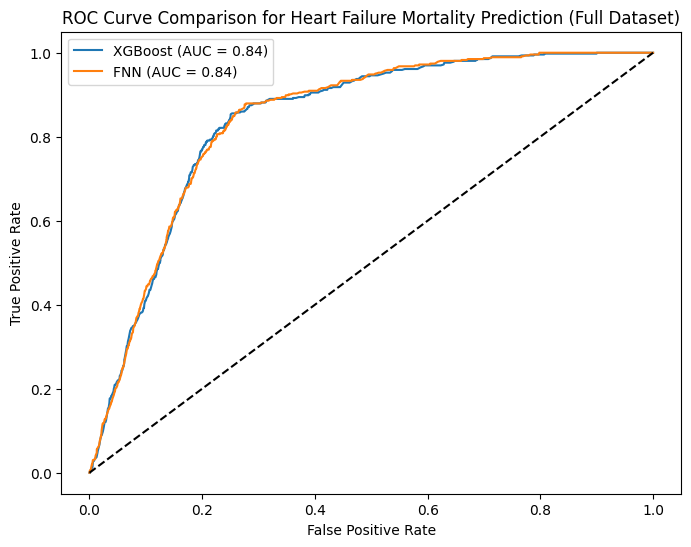

In [137]:
# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_fnn, tpr_fnn, _ = roc_curve(y_test, y_pred_proba_fnn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_metrics["AUC-ROC"]:.2f})')
plt.plot(fpr_fnn, tpr_fnn, label=f'FNN (AUC = {fnn_metrics["AUC-ROC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Heart Failure Mortality Prediction (Full Dataset)')
plt.legend()
plt.show()